## Projekt

**ZUM 24L**

**Temat**: Tworzenie zespołu modeli klasyfikacji przez wielokrotne stosowanie dowolnego algorytmu klasyfikacji do bootstrapowych prób ze zbioru trenującego z losowo wybranym podzbiorem atrybutów.

**Wojciech Gierulski, Amelia Tabor**

## Zmiany w stosunku do dokumentacji wstępnej:
* zmiana oceny jakości za pomocą krzywej PR na krzywą ROC, ponieważ biblioteka sklearn dobrze wspiera tę metodę w wersji wieloklasowej

## Opis implementacji
Zaimplementowana klasa CustomBaggingClassifier dziedziczy po klasie BaseEstimator z pakietu sklearn oraz posługuje się standardowym dla tej biblioteki interfejsem, co umożliwia łatwe wykorzystywanie jej razem z innymi gotowymi funkcjami.

Klasa jest łatwo parametryzowalna i umożliwia działanie na atrybutach zarówno numerycznych, jak i nominalnych.

### Etapy działania algorytmu
1. Dane wejściowe - pandas dataframe z danymi
2. Dla każdego modelu losowane jest (ze zwracaniem lub bez) _n_ atrybutów oraz _k_ próbek z całego zbioru treningowego. Na podstawie wylosowanych danych wydzielany jest podzbiór zbioru treningowego.
3. Dla każdego takiego podzbioru tworzony jest pipeline przetwarzający dane wstępnie. Ten pipeline obejmuje:
    * skalowanie atrybutów numerycznych za pomocą StandardScaler
    * one hot encoding atrybutów nominalnych
    * kodowanie klasy za pomocą liczb całkowitych
    Selekcja atrybutów następuje przed etapem one hot encoding, dlatego nie wystąpi sytuacja, w której odrzucane są one hot encoded kolumny stanowiące część atrybutu nominalnego w przypadku selekcji atrybutów.
4. Model bazowy jest trenowany na odpowiednim podzbiorze danych.

Na etapie predykcji, każdy model otrzymuje tylko podzbiór danych o tych atrybutach, na których został nauczony. Finalna predykcja generowana jest w oparciu o głosowanie modeli. Jeżeli model bazowy implementuje opcję _predict_proba_ to wybierana jest klasa, która uzyskała maksymalne sumaryczne prawdopodobieństwo.

### Opis parametrów wejściowych
* **estimator** - model klasyfikacji z biblioteki sklearn używany jako model bazowy
* **n_estimators** - liczba modeli w zespole
* **sampling_with_replacement** - czy losować próbki ze zwracaniem
* **sampling_with_replacement_features** - czy losować atrybuty ze zwracaniem
* **sample_size** - rozmiar próby dla pojedynczego modelu (ułamek w zakresie 0-1 względem rozmiaru całego zbioru)
* **sample_size_features** - liczba atrybutów losowana dla pojedyczego modelu (ułamek w zakresie 0-1 względem liczby wszystkich dostępnych atrybutów)
* **estimator_kwargs** - słownik z dodatkowymi argumentami dla bazowego modelu
* **categorical_features** - lista nazw kolumn z wartościami nominalnymi. reszta kolumn traktowana jest jako numeryczne

### Ocena jakości
Do oceny jakości wykorzystywane są
* k-krotna walidacja krzyżowa - główna metoda ewaluacji. W tym przypadku obliczane są następujące miary jakości:
    * **total_micro_auc** - uśrednione ze wszystkich foldów pole pod krzywą ROC wygenerowaną metodą mikro-uśredniania
    * **total_macro_auc** - uśrednione ze wszystkich foldów pole pod krzywą ROC wygenerowane metodą mikro-uśredniania
    * **total_micro_f1** - współczynnik f1 obliczony metodą mikro-uśredniania
    * **total_macro_f1** - współczynnik f1 obliczony metodą makro-uśredniania
* W pewnych miejscach rysowane są poglądowe krzywe ROC dla różnych klas. W tych przypadkach, ze względu na czytelność wykresów, krzywe nie są generowane na podstawie walidacji krzyżowej, ale na podstawie wydzielonego w innym miejscu zbioru treningowego i testowego.

W ramach eksperymentów:
1. Dla zbioru danych Wine Quality:
    1. sprawdzono jaki wpływ na działanie algorytmu mają wszystkie parametry. Sprawdzono algorytmy bazowe: drzewo decyzyjne, regresja logistyczna, svm
    2. dla każdego z powyższych algorytmów zaimplementowano krótki grid search hiperparametrów, żeby znaleźć dobry zestaw do przeprowadzania eksperymentów z pkt 1.
    3. porównano skuteczność z algorytmami bagging classifier z sklearn, random forest z sklearn oraz z pojedynczymi modelami
2. Dla zbioru danych Adult:
    1. zademonstrowano działanie implementacji na zbiorze danych z atrybutami nominalnymi oraz numerycznymi
    2. porównano skuteczność własnej implementacji baggingu z bagging classifier z sklearn, random forest z sklearn oraz z pojedynczymi modelami

---

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from bagging_classifier import CustomBaggingClassifier
from datasets import load_dataset
from tqdm import tqdm
from plot_roc import plot_roc
from utils import get_k_fold_metrics, get_train_test_metrics, fast_grid_search, n_estimators_effect, sample_size_effect, features_size_effect, replacement_effect

### Eksperymenty na zbiorze Wine Quality

In [6]:
X, y, numerical_columns, categorical_columns, label_encoder = load_dataset(name="wine")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

def preprocess(X_train, X_test):
    numerical_features = list(set(X.columns) - set(categorical_columns))
    transformer = ColumnTransformer(
        [('ct', StandardScaler(), numerical_features),
         ("ohe", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)],
        remainder='passthrough')
    transformer.fit(X_train)
    return pd.DataFrame(transformer.transform(X_train)), pd.DataFrame(transformer.transform(X_test))

def preprocess_one(X):
    numerical_features = list(set(X.columns) - set(categorical_columns))
    transformer = ColumnTransformer(
        [('ct', StandardScaler(), numerical_features),
         ("ohe", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)],
        remainder='passthrough')
    transformer.fit(X)
    return pd.DataFrame(transformer.transform(X))

X_train_transformed, X_test_transformed = preprocess(X_train, X_test)
X_transformed = preprocess_one(X)

Rozkład klas

w przypadku zbioru danych Wine Quality usuwane są 2 najmniej liczne klasy (5 próbek i 30 próbek) ponieważ jest to zbyt mało, żeby się dobrze nauczyć i zaburzałyby uśrednienia.

In [7]:
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0  216]
 [   1 2138]
 [   2 2836]
 [   3 1079]
 [   4  193]]


#### Eksperymenty modelem SVM jako modelem bazowym do zespołu

Najpierw przeprowadzany jest prosty grid search, żeby znaleźć dobrze działający zestaw parametrów SVM do dalszych eksperymentów.
Grid search walidowany jest za pomocą 5-krotnej walidacji krzyżowej, dla modelu CustomBaggingClassifier.

In [8]:
grid = [{'loss': ['hinge', 'squared_hinge'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}]

total_metrics = fast_grid_search(grid, LinearSVC, categorical_columns, X, y)
total_metrics.sort_values(by='sum')

100%|██████████| 12/12 [01:40<00:00,  8.37s/it]


,C,loss,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,1.00,hinge,0.689478,0.608991,0.426344,0.227284,1.952097
0,0.01,hinge,0.708568,0.572978,0.474154,0.213289,1.968990
0,10.00,hinge,0.708519,0.589207,0.450480,0.224752,1.972959
0,0.10,hinge,0.706593,0.601118,0.442743,0.227415,1.977868
0,1000.00,hinge,0.741654,0.585275,0.439810,0.241231,2.007970
0,1.00,squared_hinge,0.746084,0.568690,0.521509,0.237386,2.073669
0,10.00,squared_hinge,0.745404,0.568137,0.525842,0.239572,2.078955
0,0.10,squared_hinge,0.742809,0.567724,0.528008,0.241140,2.079682
0,0.01,squared_hinge,0.746111,0.570546,0.536059,0.245662,2.098378
0,100.00,hinge,0.766960,0.587497,0.505411,0.241434,2.101301


Model z najlepszymi wynikami wybrany do dalszych eksperymentów: loss=squared_hinge, C=100

---

##### Wpływ liczby modeli w zespole na wyniki klasyfikacji dla modelu SVM i zbioru danych Wine Quality
W tym przypadku używana jest walidacja na zbiorze testowym, a nie walidacja krzyżowa.

100%|██████████| 7/7 [03:14<00:00, 27.80s/it]


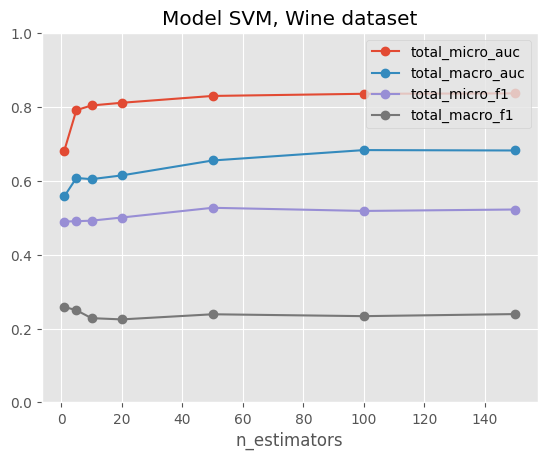

In [9]:
n_estimators_arr = [1,5,10,20,50,100,150]
estimator_kwargs = {'loss': 'squared_hinge', 'C': 100}

n_estimators_effect(LinearSVC, n_estimators_arr, categorical_columns, X_train, X_test, y_train, y_test, estimator_kwargs, "Model SVM, Wine dataset")

Zwiększanie liczby modeli w zespole powyżej 100 nie przynosi poprawy. Jako wartość optymalną wybrano 100 do dalszych eksperymentów.

---

##### Wpływ wielkości losowanej próby na wyniki klasyfikacji dla modelu SVM i zbioru danych Wine Quality
W tym przypadku używana jest walidacja na zbiorze testowym, a nie walidacja krzyżowa. Jako liczbę modeli w zespole przyjęto 100, czyli optymalną wartość z poprzedniego eksperymentu.

100%|██████████| 5/5 [03:37<00:00, 43.53s/it]


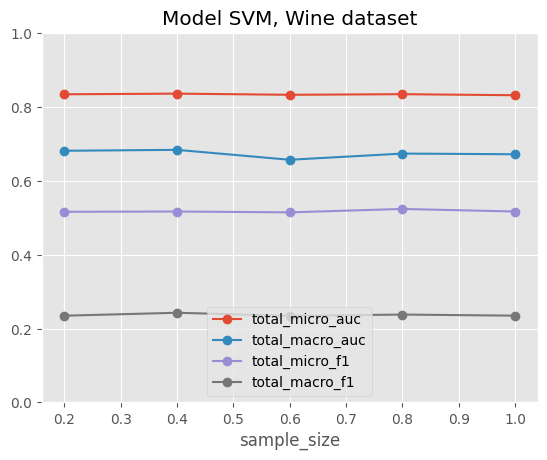

In [10]:
sample_size_arr = [0.2, 0.4, 0.6, 0.8, 1]

sample_size_effect(LinearSVC, sample_size_arr, categorical_columns, X_train, X_test, y_train, y_test, estimator_kwargs, "Model SVM, Wine dataset", 100)

Rozmiar losowanej próby nie ma dużego wpływu na wyniki. Jako wartość optymalną wybrano 0.8.

---

##### Wpływ liczby losowanych atrybutów na wyniki klasyfikacji dla modelu SVM i zbioru danych Wine Quality

W tym przypadku używana jest walidacja na zbiorze testowym, a nie walidacja krzyżowa. Przyjęto parametry uznane za optymalne w poprzednich eksperymentach.

100%|██████████| 5/5 [04:31<00:00, 54.39s/it]


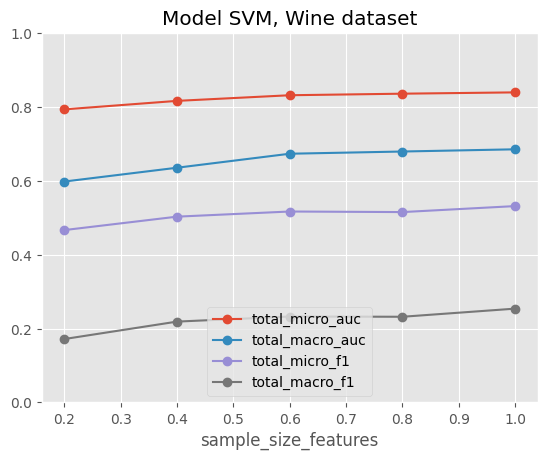

In [11]:
sample_size_features_arr = [0.2, 0.4, 0.6, 0.8, 1]
features_size_effect(LinearSVC, sample_size_features_arr, categorical_columns, X_train, X_test, y_train, y_test, estimator_kwargs, "Model SVM, Wine dataset", 100, 0.8)

Jakość modelu zwiększa sie przy zwiększaniu liczby atrybutów. Najlepsze wyniki uzyskuje się dla wszystkich atrybutów. Przyjęto więc parameetr sample_size_feature=1.0


---

##### Jak losowanie ze zwracaniem i bez zwracania wypływa na wyniki dla modelu SVM i zbioru danych Wine Quality

W tym przypadku używana jest walidacja na zbiorze testowym, a nie walidacja krzyżowa. Przyjęto parametry uznane za optymalne w poprzednich eksperymentach.

100%|██████████| 4/4 [04:06<00:00, 61.61s/it]


,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum,method
0,0.827830,0.647770,0.512761,0.229739,2.218100,"{'samples': True, 'features': True}"
0,0.834279,0.672617,0.526682,0.239157,2.272735,"{'samples': False, 'features': True}"
0,0.836483,0.678281,0.529002,0.254692,2.298458,"{'samples': True, 'features': False}"
0,0.836121,0.676632,0.527456,0.250073,2.290281,"{'samples': False, 'features': False}"


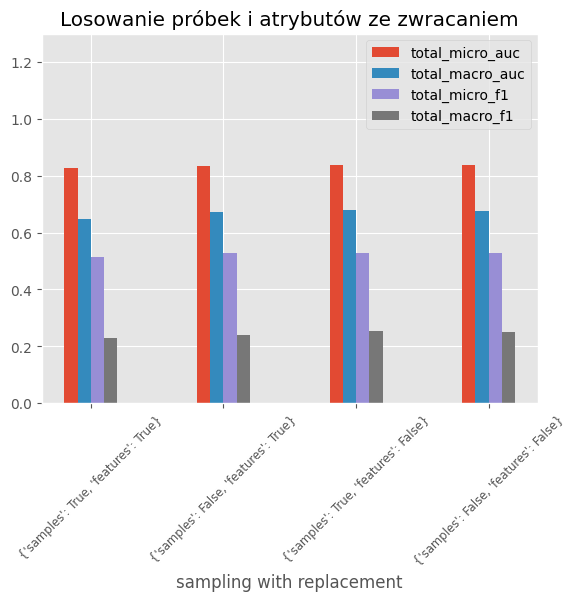

In [12]:
replacements_arr = [{'samples': True, 'features': True},
                   {'samples': False, 'features': True},
                   {'samples': True, 'features': False},
                   {'samples': False, 'features': False}
                   ]

total_metrics = replacement_effect(LinearSVC, replacements_arr, categorical_columns, X_train, X_test, y_train, y_test, estimator_kwargs, "Model SVM, Wine dataset", 100, 0.8, 1.0)
total_metrics['method'] = [str(rep) for rep in replacements_arr]
total_metrics

Losowanie bez zwracania i ze zwracaniem nie ma duzego wpływu na jakość modelu w przypadku atrybutów i próbek. Losowanie bez zwracania zarówno dla atrybutów ze zwracaniem dla próbek daje minimalnie lepsze rezultaty niż pozostałe kombinacje, dlatego takie parametry przyjęto w dalszej części.

---

##### Finalna ewaluacja zespołu modeli

W tym przypadku wykorzystywane są najlepsze parametry z porzednich eksperymentów oraz walidacja krzyżowa.

Obliczanie miar jakości:

In [13]:
model = CustomBaggingClassifier(estimator=LinearSVC,
                                sample_size=0.8,
                                sample_size_features=1,
                                sampling_with_replacement_features=False,
                                sampling_with_replacement=True,
                                n_estimators=100,
                                categorical_features=categorical_columns,
                                estimator_kwargs={'loss': 'squared_hinge', 'C': 100})
metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.843666,0.697018,0.534045,0.258321,2.333049


---

Obliczanie krzywych ROC. W przypadku wykreślania krzywych stosowany jest podział na test i train.

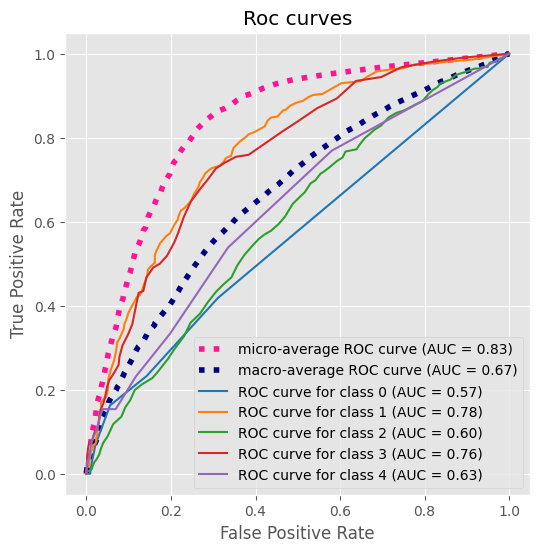

In [14]:
model = CustomBaggingClassifier(estimator=LinearSVC,
                                sample_size=0.8,
                                sample_size_features=1,
                                sampling_with_replacement_features=False,
                                sampling_with_replacement=True,
                                n_estimators=100,
                                categorical_features=categorical_columns,
                                estimator_kwargs={'loss': 'squared_hinge', 'C': 100})
model.fit(X_train, y_train)
y_pred = model.predict(X_test, predict_proba=True)
plot_roc(y_pred, y_test, model.n_classes)

Po metrykach i krzywych ROC widać, że model słabo radzi sobie z niezbalansowanym rozkładem klas. Można tu rozważyć techniki takie jak over/under sampling lub wagi klas.

---

##### Porównanie z pojedynczym modelem SVM
Najpierw przeprowadzany jest Grid Search, żeby znaleźć optymalne parametry pojedynczego modelu SVM. Następnie ewaluacja przeprowadzana jest w sposób analogiczny jak w przypaku zespołu modeli.

In [15]:
grid = [{'loss': ['hinge', 'squared_hinge'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}]
sklearn_grid = ParameterGrid(grid)
total_metrics = pd.DataFrame()

for param_grid in tqdm(sklearn_grid):
    model = CustomBaggingClassifier(estimator=LinearSVC,
                                    sample_size=1,
                                    sample_size_features=1,
                                    sampling_with_replacement_features=False,
                                    sampling_with_replacement=False,
                                    n_estimators=1,
                                    categorical_features=categorical_columns,
                                    estimator_kwargs=param_grid)
    metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
    row = pd.concat([pd.DataFrame([param_grid]), metrics], axis=1)
    total_metrics = pd.concat([total_metrics, row])

total_metrics.sort_values(by='sum')

100%|██████████| 12/12 [00:30<00:00,  2.56s/it]


,C,loss,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,1000.00,hinge,0.635851,0.544865,0.417362,0.240609,1.838686
0,10.00,hinge,0.637789,0.554498,0.420462,0.232018,1.844768
0,1000.00,squared_hinge,0.639228,0.547637,0.422765,0.244023,1.853653
0,1.00,hinge,0.650073,0.556170,0.440117,0.248385,1.894745
0,0.10,hinge,0.656164,0.555968,0.449863,0.235993,1.897988
0,0.01,hinge,0.672893,0.548991,0.476628,0.224291,1.922803
0,100.00,hinge,0.676376,0.550134,0.482202,0.254335,1.963048
0,100.00,squared_hinge,0.674928,0.567755,0.479885,0.286938,2.009506
0,0.01,squared_hinge,0.707424,0.558790,0.531879,0.248103,2.046195
0,10.00,squared_hinge,0.707424,0.559599,0.531878,0.252176,2.051076


---

Następnie wykreślane są krzywe ROC dla modelu z najlepszymi parametrami

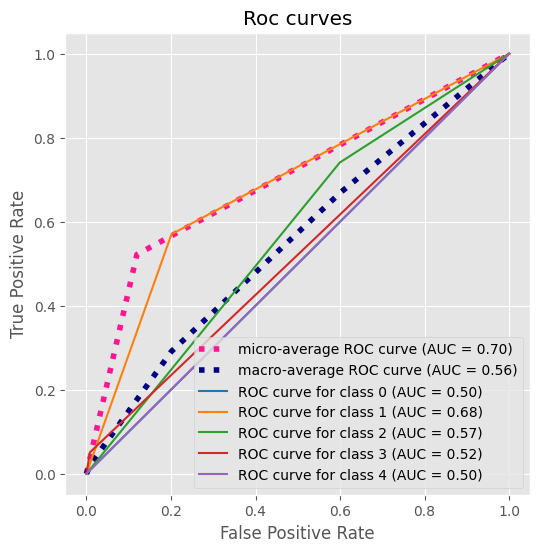

In [16]:
model = CustomBaggingClassifier(estimator=LinearSVC,
                        sample_size=1,
                        sample_size_features=1,
                        sampling_with_replacement_features=False,
                        sampling_with_replacement=False,
                        n_estimators=1,
                        categorical_features=categorical_columns,
                        estimator_kwargs={'loss': 'squared_hinge', 'C': 10})
model.fit(X_train, y_train)
y_pred = model.predict(X_test, predict_proba=True)
plot_roc(y_pred, y_test, model.n_classes)

Okazuje się, że zastosowanie metody Bagging pozwala znacząco zwiększyć skuteczność w przypadku modelu SVM i tego zbioru danych. Wszystkie metryki są wyższe.

---

#### Eksperymenty modelem Logistic Regression jako modelem bazowym do zespołu

Najpierw przeprowadzany jest prosty grid search, żeby znaleźć dobrze działający zestaw parametrów Logistic Regression do dalszych eksperymentów.
Grid search walidowany jest za pomocą 5-krotnej walidacji krzyżowej, dla modelu CustomBaggingClassifier.

In [17]:
grid = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

total_metrics = fast_grid_search(grid, LogisticRegression, categorical_columns, X, y)
total_metrics.sort_values(by='sum')

100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


,C,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.001,0.831317,0.712326,0.517331,0.227514,2.288487
0,0.010,0.842971,0.733548,0.525381,0.253456,2.355355
0,1.000,0.848961,0.749630,0.536059,0.282803,2.417454
0,10.000,0.850229,0.750032,0.536676,0.289953,2.426889
0,1000.000,0.849979,0.750687,0.539461,0.287280,2.427407
0,0.100,0.849847,0.748822,0.541165,0.289861,2.429695
0,100.000,0.850338,0.752115,0.541319,0.291310,2.435082


Model wybrany do dalszych eksperymentów: C=100

---

##### Wpływ liczby modeli w zespole na wyniki klasyfikacji dla modelu Logistic Regression i zbioru danych Wine Quality

100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


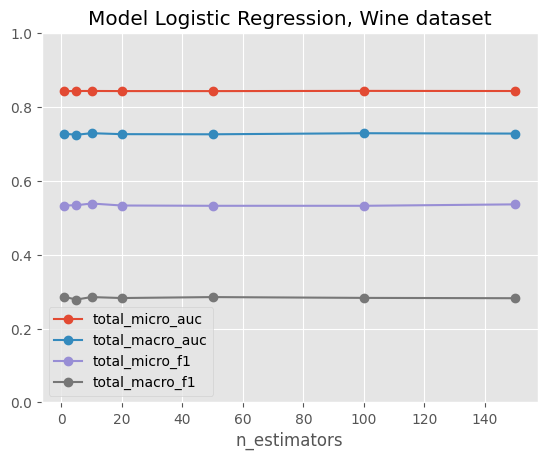

In [18]:
n_estimators_arr = [1,5,10,20,50,100,150]
estimator_kwargs = {'C': 100}

n_estimators_effect(LogisticRegression, n_estimators_arr, categorical_columns, X_train, X_test, y_train, y_test, estimator_kwargs, "Model Logistic Regression, Wine dataset")

Zwiększanie liczby modeli powyżej 20 nie przynosi poprawy. Algorytm Logistic Regression potrzebuje mniej modeli w zespole do stabilizacji wyników. W dalszej części przyjęto n_estimators=20.

---

##### Wpływ wielkości losowanej próby na wyniki klasyfikacji dla modelu Logistic Regression i zbioru danych Wine Quality

100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


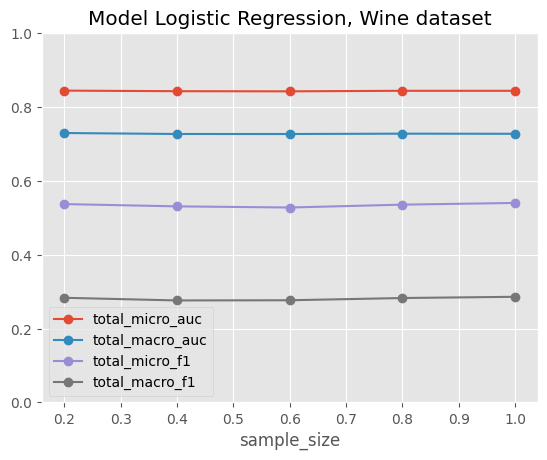

In [19]:
sample_size_arr = [0.2, 0.4, 0.6, 0.8, 1]

sample_size_effect(LogisticRegression, sample_size_arr, categorical_columns, X_train, X_test, y_train, y_test, estimator_kwargs, "Model Logistic Regression, Wine dataset", 20)

Rozmiar losowanej próby nie ma dużego wpływu na wyniki. Jako wartość optymalną wybrano 0.8.

---

##### Wpływ liczby losowanych atrybutów na wyniki klasyfikacji dla modelu Logistic Regression i zbioru danych Wine Quality

100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


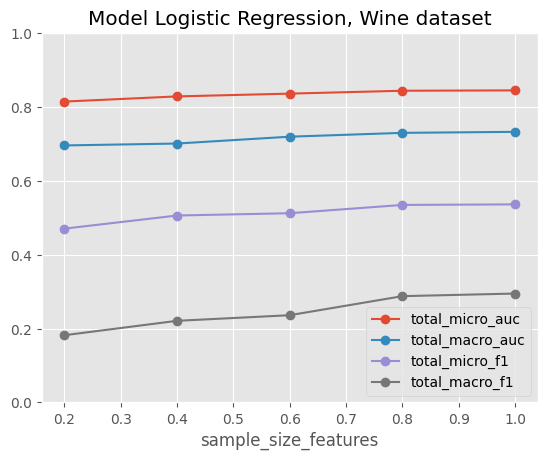

In [20]:
sample_size_features_arr = [0.2, 0.4, 0.6, 0.8, 1]
features_size_effect(LogisticRegression, sample_size_features_arr, categorical_columns, X_train, X_test, y_train, y_test, estimator_kwargs, "Model Logistic Regression, Wine dataset", 20, 0.8)

Jakość modelu zwiększa sie przy zwiększaniu liczby atrybutów. Najlepsze wyniki uzyskuje się dla wszystkich atrybutów. Przyjęto więc parameetr sample_size_feature=1.0

---

##### Wpływ losowania ze zwracaniem i bez zwracania dla modelu Logistic Regression i zbioru danych Wine Quality

100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum,method
0,0.842063,0.727074,0.529002,0.267890,2.366029,"{'samples': True, 'features': True}"
0,0.840789,0.725196,0.523589,0.264003,2.353576,"{'samples': False, 'features': True}"
0,0.844083,0.731984,0.535189,0.294705,2.405962,"{'samples': True, 'features': False}"
0,0.844537,0.733018,0.534416,0.295001,2.406972,"{'samples': False, 'features': False}"


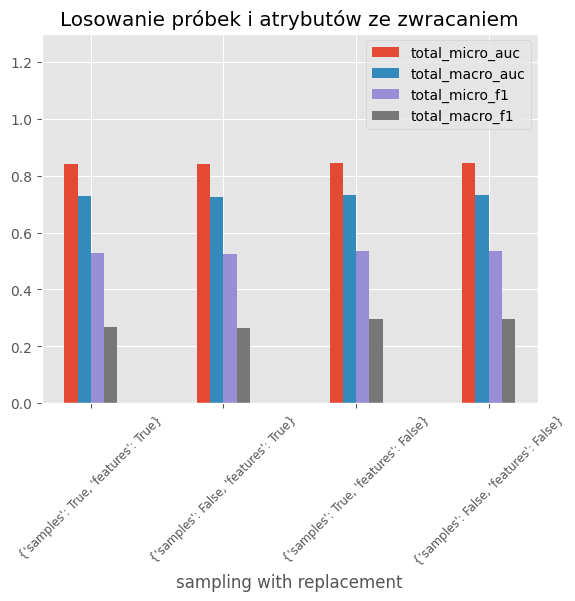

In [21]:
replacements_arr = [{'samples': True, 'features': True},
                   {'samples': False, 'features': True},
                   {'samples': True, 'features': False},
                   {'samples': False, 'features': False}
                   ]

total_metrics = replacement_effect(LogisticRegression, replacements_arr, categorical_columns, X_train, X_test, y_train, y_test, estimator_kwargs, "Model Logistic Regression, Wine dataset", 20, 0.8, 1.0)
total_metrics['method'] = [str(rep) for rep in replacements_arr]
total_metrics

Losowanie bez zwracania i ze zwracaniem nie ma duzego wpływu na jakość modelu w przypadku atrybutów i próbek. Losowanie bez zwracania dla atrybutów i próbek daje minimalnie lepsze rezultaty, dlatego takie parametry przyjęto w dalszej części.

---

##### Finalna ewaluacja zespołu modeli - k-krotna walidacja

In [22]:
model = CustomBaggingClassifier(estimator=LogisticRegression,
                                sample_size=0.8,
                                sample_size_features=1,
                                sampling_with_replacement_features=False,
                                sampling_with_replacement=False,
                                n_estimators=20,
                                categorical_features=categorical_columns,
                                estimator_kwargs={'C': 100})
metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
metrics.sort_values(by='sum')

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.85364,0.757491,0.545343,0.303128,2.459602


Wszystkie metryki są wyższe niż w przypadku SVM. Taki model działa lepiej na tym zbiorze danych.

---

##### Obliczanie poglądowych krzywych ROC dla poziału test train

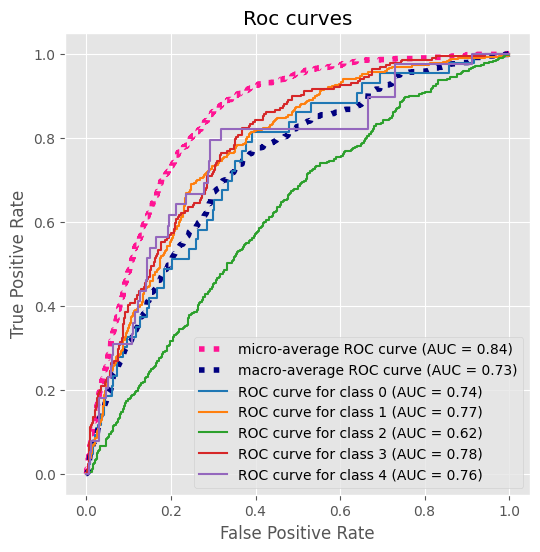

In [24]:
model = CustomBaggingClassifier(estimator=LogisticRegression,
                                sample_size=0.8,
                                sample_size_features=1,
                                sampling_with_replacement_features=False,
                                sampling_with_replacement=False,
                                n_estimators=20,
                                categorical_features=categorical_columns,
                                estimator_kwargs={'C': 100})
model.fit(X_train, y_train)
y_pred = model.predict(X_test, predict_proba=True)
plot_roc(y_pred, y_test, model.n_classes)

Krzywe ROC dla poszczególnych klas pokazują, że tutaj klasyfikator lepiej radzi sobie z problemem niezbalansowanych klas.

---

##### Porównanie z pojedynczym modelem LogisticRegression
Najpierw liczony jest grid search po parametrach, żeby wzynaczyć optymalny zestaw.

In [25]:
grid = [{'C': [0.01, 0.01, 0.1, 1, 10, 100, 1000]}]
sklearn_grid = ParameterGrid(grid)
total_metrics = pd.DataFrame()

for param_grid in tqdm(sklearn_grid):
    model = CustomBaggingClassifier(estimator=LogisticRegression,
                                    sample_size=1,
                                    sample_size_features=1,
                                    sampling_with_replacement_features=False,
                                    sampling_with_replacement=False,
                                    n_estimators=1,
                                    categorical_features=categorical_columns,
                                    estimator_kwargs=param_grid)
    metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
    row = pd.concat([pd.DataFrame([param_grid]), metrics], axis=1)
    total_metrics = pd.concat([total_metrics, row])

total_metrics.sort_values(by='sum')

100%|██████████| 7/7 [00:01<00:00,  3.61it/s]


,C,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.01,0.850944,0.747384,0.543486,0.286245,2.428059
0,0.01,0.850944,0.747384,0.543486,0.286245,2.428059
0,0.10,0.853659,0.756801,0.543795,0.299373,2.453628
0,100.00,0.853735,0.757571,0.545033,0.303830,2.460169
0,1000.00,0.853734,0.757585,0.545033,0.303830,2.460182
0,10.00,0.853739,0.757582,0.545033,0.303830,2.460185
0,1.00,0.853747,0.757576,0.545343,0.303799,2.460464


Ciekawym wnioskiem jest to, że dla pojedynczgo modelu osiągane są identyczne wyniki jak dla zespołu modeli. Bagging nie jest skuteczny w przypadku tego algorytmu.

---

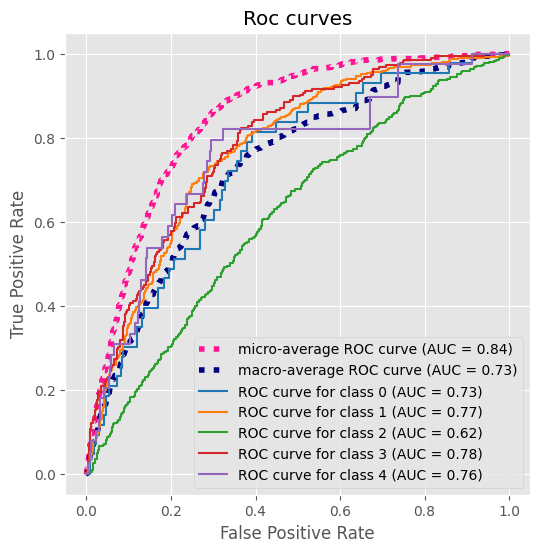

In [26]:
model = CustomBaggingClassifier(estimator=LogisticRegression,
                        sample_size=1,
                        sample_size_features=1,
                        sampling_with_replacement_features=False,
                        sampling_with_replacement=False,
                        n_estimators=20,
                        categorical_features=categorical_columns,
                        estimator_kwargs={'C': 1})
model.fit(X_train, y_train)
y_pred = model.predict(X_test, predict_proba=True)
plot_roc(y_pred, y_test, model.n_classes)

---

#### Eksperymenty z modelem Decision Tree jako modelem bazowym

Najpierw przeprowadzany jest prosty grid search, żeby znaleźć dobrze działający zestaw parametrów Decision Tree do dalszych eksperymentów.
Grid search walidowany jest za pomocą 5-krotnej walidacji krzyżowej, dla modelu CustomBaggingClassifier.

In [28]:
pd.options.display.max_columns = 99
pd.options.display.max_rows = 99

In [29]:
grid = [{'max_depth': [3,4,5,6,8], 'min_samples_split': [2,4,6], "min_samples_leaf": [1,2,4,6]}]

total_metrics = fast_grid_search(grid, DecisionTreeClassifier, categorical_columns, X, y)
total_metrics.sort_values(by='sum')

100%|██████████| 60/60 [00:22<00:00,  2.67it/s]


,max_depth,min_samples_leaf,min_samples_split,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,3,6,2,0.846876,0.738473,0.530328,0.262379,2.378056
0,3,2,4,0.846282,0.734299,0.530948,0.270067,2.381596
0,3,1,4,0.846805,0.738582,0.533269,0.266454,2.385111
0,3,6,4,0.848178,0.742677,0.534349,0.261282,2.386486
0,3,6,6,0.846179,0.734696,0.528936,0.277116,2.386927
0,3,4,4,0.846653,0.741283,0.533577,0.266772,2.388286
0,3,2,6,0.845198,0.736806,0.532805,0.273564,2.388373
0,3,2,2,0.847700,0.739426,0.536208,0.271313,2.394648
0,3,4,6,0.847550,0.743303,0.534353,0.270314,2.395520
0,3,1,2,0.847149,0.734574,0.535126,0.279545,2.396395


Model wybrany do dalszych eksperymentów: max_depth=8, min_samples_leaf=1, min_samples_split=2

---

##### Wpływ liczby modeli w zespole na wyniki klasyfikacji dla modelu Decision Tree i zbioru danych Wine Quality

100%|██████████| 7/7 [00:05<00:00,  1.18it/s]


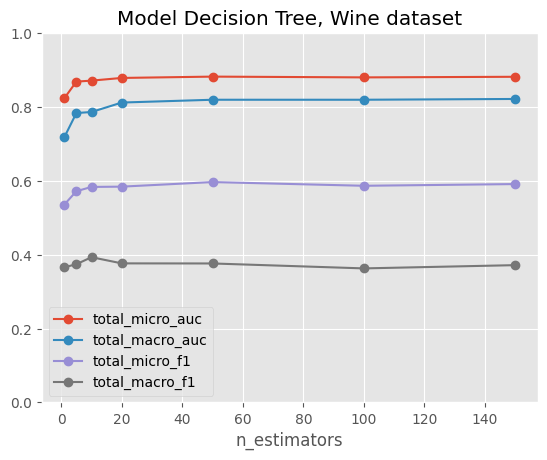

In [30]:
n_estimators_arr = [1,5,10,20,50,100,150]
estimator_kwargs = {'max_depth':8, 'min_samples_leaf':1, 'min_samples_split':2}

n_estimators_effect(DecisionTreeClassifier, n_estimators_arr, categorical_columns, X_train, X_test, y_train, y_test, estimator_kwargs, "Model Decision Tree, Wine dataset")

Zwiększanie liczby modeli w zespole powyżej 20 nie przynosi poprawy. Jako wartość optymalną wybrano 20 do dalszych eksperymentów.

---

##### Wpływ wielkości losowanej próby na wyniki klasyfikacji dla modelu Decision Tree i zbioru danych Wine Quality

100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


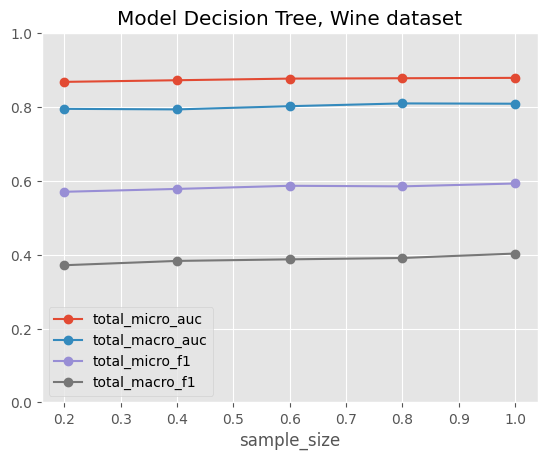

In [31]:
sample_size_arr = [0.2, 0.4, 0.6, 0.8, 1]

sample_size_effect(DecisionTreeClassifier, sample_size_arr, categorical_columns, X_train, X_test, y_train, y_test, estimator_kwargs, "Model Decision Tree, Wine dataset", 20)

Wyniki przestają się poprawiać po przekroczeniu progu 0.8. Jako wartość optymalną wybrano 0.8.

---

##### Wpływ liczby losowanych atrybutów na wyniki klasyfikacji dla modelu Decision Tree i zbioru danych Wine Quality

100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


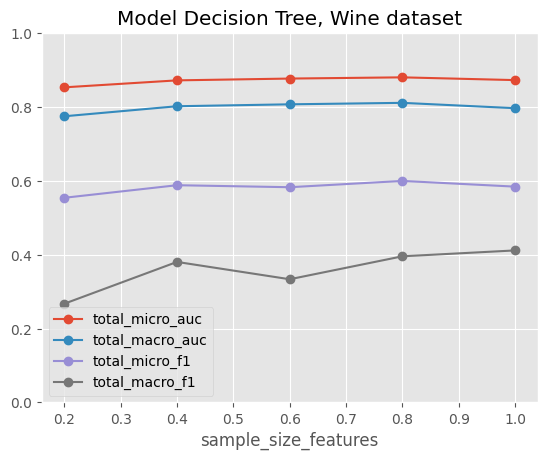

In [32]:
sample_size_features_arr = [0.2, 0.4, 0.6, 0.8, 1]
features_size_effect(DecisionTreeClassifier, sample_size_features_arr, categorical_columns, X_train, X_test, y_train, y_test, estimator_kwargs, "Model Decision Tree, Wine dataset", 20, 0.8)

Jakość modelu zwiększa sie przy zwiększaniu liczby atrybutów. Najlepsze wyniki osiągane są dla wartości 0.8. Później wyniki się pogarszają. Przyjęto więc parameetr sample_size_feature=0.8.

---

Losowanie ze zwracaniem i bez zwracania dla modelu Decision Tree i zbioru danych Wine Quality

100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum,method
0,0.873031,0.804853,0.583913,0.348825,2.610622,"{'samples': True, 'features': True}"
0,0.874023,0.802150,0.578500,0.374736,2.629409,"{'samples': False, 'features': True}"
0,0.875135,0.800047,0.580046,0.363261,2.618490,"{'samples': True, 'features': False}"
0,0.873098,0.794407,0.581593,0.357436,2.606533,"{'samples': False, 'features': False}"


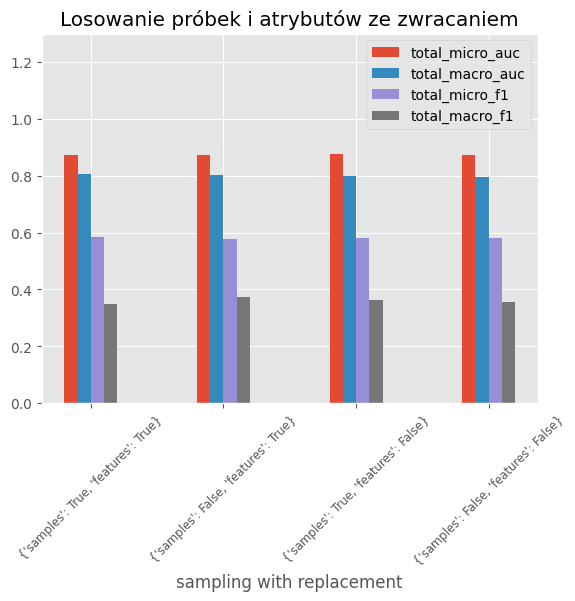

In [33]:
replacements_arr = [{'samples': True, 'features': True},
                   {'samples': False, 'features': True},
                   {'samples': True, 'features': False},
                   {'samples': False, 'features': False}
                   ]

total_metrics = replacement_effect(DecisionTreeClassifier, replacements_arr, categorical_columns, X_train, X_test, y_train, y_test, estimator_kwargs, "Model Decision Tree, Wine dataset", 20, 0.8, 0.8)
total_metrics['method'] = [str(rep) for rep in replacements_arr]
total_metrics

W przypadku tego klasyfikatora wszystkie wyniki są niemalże identyczne. Przyjęto {'samples': False, 'features': False}

---

##### Finalna ewaluacja zespołu modelu - k-krotna walidacja

In [34]:
model = CustomBaggingClassifier(estimator=DecisionTreeClassifier,
                                sample_size=0.8,
                                sample_size_features=0.8,
                                sampling_with_replacement_features=False,
                                sampling_with_replacement=False,
                                n_estimators=20,
                                categorical_features=categorical_columns,
                                estimator_kwargs={'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2})
metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.885476,0.824828,0.610956,0.388387,2.709646


Model Decision Tree w Bagging daje najlepsze rezultaty spośród dotychczas przetestowanych.

---

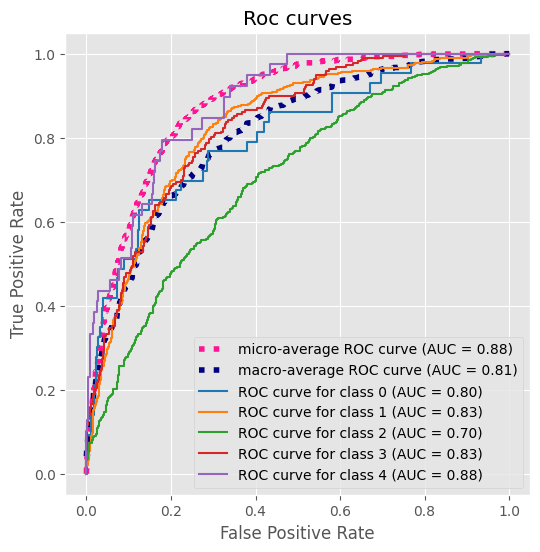

In [36]:
model = CustomBaggingClassifier(estimator=DecisionTreeClassifier,
                                sample_size=0.8,
                                sample_size_features=0.8,
                                sampling_with_replacement_features=False,
                                sampling_with_replacement=False,
                                n_estimators=20,
                                categorical_features=categorical_columns,
                                estimator_kwargs={'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2})
model.fit(X_train, y_train)
y_pred = model.predict(X_test, predict_proba=True)
plot_roc(y_pred, y_test, model.n_classes)

Decision Tree w Bagging również najlepiej radzi sobie z niezbalansowaniem klas.

---

##### Porównanie z pojedynczym modelem Decision Tree - grid search po parametrach

In [37]:
grid = [{'max_depth': [3,4,5,6,8], 'min_samples_split': [2,4,6], "min_samples_leaf": [1,2,4,6]}]
sklearn_grid = ParameterGrid(grid)
total_metrics = pd.DataFrame()

for param_grid in tqdm(sklearn_grid):
    model = CustomBaggingClassifier(estimator=DecisionTreeClassifier,
                                    sample_size=1,
                                    sample_size_features=1,
                                    sampling_with_replacement_features=False,
                                    sampling_with_replacement=False,
                                    n_estimators=1,
                                    categorical_features=categorical_columns,
                                    estimator_kwargs=param_grid)
    metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
    row = pd.concat([pd.DataFrame([param_grid]), metrics], axis=1)
    total_metrics = pd.concat([total_metrics, row])

total_metrics.sort_values(by='sum')

100%|██████████| 60/60 [00:07<00:00,  7.64it/s]


,max_depth,min_samples_leaf,min_samples_split,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,3,1,2,0.841444,0.713115,0.524605,0.274409,2.353573
0,3,6,6,0.841444,0.713115,0.524605,0.274409,2.353573
0,3,6,4,0.841444,0.713115,0.524605,0.274409,2.353573
0,3,6,2,0.841444,0.713115,0.524605,0.274409,2.353573
0,3,4,4,0.841444,0.713115,0.524605,0.274409,2.353573
0,3,4,2,0.841444,0.713115,0.524605,0.274409,2.353573
0,3,4,6,0.841444,0.713115,0.524605,0.274409,2.353573
0,3,2,4,0.841444,0.713115,0.524605,0.274409,2.353573
0,3,2,2,0.841444,0.713115,0.524605,0.274409,2.353573
0,3,1,6,0.841444,0.713115,0.524605,0.274409,2.353573


Najlepsze wyniki osiągane dla: max_depth=8, min_samples_leaf=1, min_samples_split_6. Wyniki są znacznie gorsze niż dla wersji z Baggingiem.

---

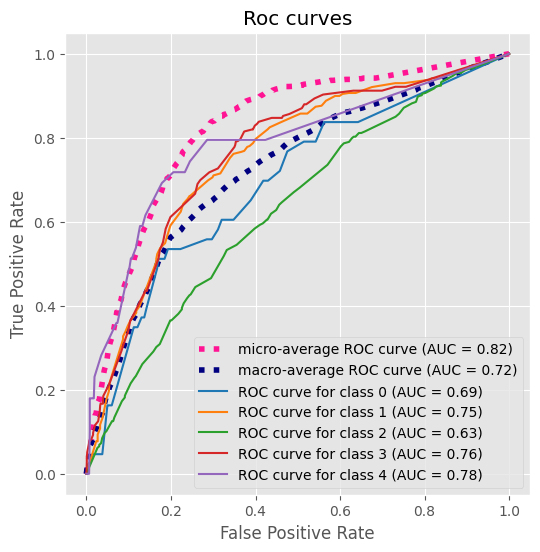

In [38]:
model = CustomBaggingClassifier(estimator=DecisionTreeClassifier,
                        sample_size=1,
                        sample_size_features=1,
                        sampling_with_replacement_features=False,
                        sampling_with_replacement=False,
                        n_estimators=1,
                        categorical_features=categorical_columns,
                        estimator_kwargs={'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 6})
model.fit(X_train, y_train)
y_pred = model.predict(X_test, predict_proba=True)
plot_roc(y_pred, y_test, model.n_classes)

---

#### Porównanie z RandomForest z biblioteki sklearn

In [40]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [41]:
model = RandomForestClassifier(n_estimators=20, max_depth=8, min_samples_leaf=1, min_samples_split=2)
metrics = get_k_fold_metrics(model, splits=5, X=X_transformed, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.881732,0.81841,0.598264,0.358763,2.657168


Porównanie z BaggingClassifier z sklearn dla modeli: SVM, LogisticRegression i DecisionTree

In [42]:
model = BaggingClassifier(estimator=LinearSVC(loss='squared_hinge', C=100), n_estimators=100, bootstrap_features=False, bootstrap=True, max_samples=0.8, max_features=1)
metrics = get_k_fold_metrics(model, splits=5, X=X_transformed, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.790894,0.579813,0.438719,0.123639,1.933065


In [43]:
model = BaggingClassifier(estimator=LogisticRegression(C=100), n_estimators=20, bootstrap_features=False, bootstrap=False, max_samples=0.8, max_features=1)
metrics = get_k_fold_metrics(model, splits=5, X=X_transformed, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.810594,0.694241,0.443517,0.131959,2.080311


In [45]:
model = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=8, min_samples_leaf=1, min_samples_split=2), n_estimators=20, bootstrap_features=False, bootstrap=False, max_samples=0.8, max_features=0.8)
metrics = get_k_fold_metrics(model, splits=5, X=X_transformed, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.884424,0.819091,0.604145,0.37697,2.68463


---

#### Podsumowanie eksperymentów na zbiorze Wine Quality

W poniższej tabeli znajdują się wszystkie metryki dla walidacji krzyżowej i testowanych modeli.

|             Zbiór danych - Wine Quality             | micro_avg_roc_auc | macro_avg_roc_auc | f1_micro_avg | f1_macro_avg |
|:---------------------------------------------------:|:-----------------:|:-----------------:|:------------:|:------------:|
|             CustomBaggingClassifier(SVM)            |        0,84       |        0,70       |     0,53     |     0,26     |
|     CustomBaggingClassifier(LogisticRegression)     |        0,85       |        0,76       |     0,55     |     0,30     |
|        CustomBaggingClassifier(DecisionTree)        |        0,89       |        0,82       |     0,61     |     0,39     |
|                  **sklearn** - SVM                  |        0,71       |        0,56       |     0,53     |     0,25     |
|           **sklearn** - LogisticRegression          |        0,85       |        0,76       |     0,55     |     0,30     |
|              **sklearn** - DecisionTree             |        0,83       |        0,74       |     0,55     |     0,35     |
|              **sklearn** - RandomForest             |        0,88       |        0,82       |     0,60     |     0,36     |
|         **sklearn** - BaggingClassifier(SVM)        |        0,79       |        0,58       |     0,44     |     0,12     |
| **sklearn** - BaggingClassifier(LogisticRegression) |        0,81       |        0,69       |     0,44     |     0,13     |
|    **sklearn** - BaggingClassifier(DecisionTree)    |        0,88       |        0,82       |     0,60     |     0,38     |

Obserwacje:
* modele drzew decyzyjnych najlepiej radzą sobie z tym problemem klasyfikacji
* w modelu regresji logistycznej nie ma sensu stosować baggingu bo nie poprawia to wyników
* model random forest osiąga identyczne rezultaty jak własna implementacja baggingu z modelem bazowym drzewa decyzyjnego. Wskazuje to na poprawność implementacji.
* bagging classifier z biblioteki sklearn osiąga gorsze wyniki niż własna implementacja. Jedna z różnic implementacyjnych jest taka, że we własnej implementacji normalizacja zachodzi dla każdego modelu oddzielnie, a w implementacji sklearn normalizację trzeba zrobić na początku dla całego zbioru danych. Najwidoczniej wiele różnych normalizacji pomaga w generalizacji.
* Modele pojedyncze osiągają zawsze wyniki nie lepsze niż odpowiadające modele bagging


---

### Eksperymenty na zbiorze Adult dataset

Wszystkie parametry zostały dokładniej zbadane na poprzednim zbiorze danych. W tej sekcji znajduje się demonstracja działania algorytmu na innym zbiorze danych (z kolumnami nominalnymi i numerycznymi). Dla każdego algorytmu obliczono metryki zgodnie z k-krotną walidacją krzyżową.

In [47]:
X, y, numerical_columns, categorical_columns, label_encoder = load_dataset(name="adult")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

def preprocess(X_train, X_test):
    numerical_features = list(set(X.columns) - set(categorical_columns))
    transformer = ColumnTransformer(
        [('ct', StandardScaler(), numerical_features),
         ("ohe", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)],
        remainder='passthrough')
    transformer.fit(X_train)
    return pd.DataFrame(transformer.transform(X_train)), pd.DataFrame(transformer.transform(X_test))

def preprocess_one(X):
    numerical_features = list(set(X.columns) - set(categorical_columns))
    transformer = ColumnTransformer(
        [('ct', StandardScaler(), numerical_features),
         ("ohe", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)],
        remainder='passthrough')
    transformer.fit(X)
    return pd.DataFrame(transformer.transform(X))

X_train_transformed, X_test_transformed = preprocess(X_train, X_test)
X_transformed = preprocess_one(X)

#### Model Bagging SVM - implementacja własna

In [50]:
model = CustomBaggingClassifier(estimator=LinearSVC,
                                sample_size=0.8,
                                sample_size_features=1,
                                sampling_with_replacement_features=False,
                                sampling_with_replacement=False,
                                n_estimators=20,
                                categorical_features=categorical_columns,
                                estimator_kwargs={"loss": "squared_hinge", "C": 100})
metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.892531,0.892531,0.846685,0.77334,3.405088


Na zbiorze danych Adult udaje się uzyskać dobre wyniki od razu.

#### Model Bagging Logistic Regression - implementacja własna

In [51]:
model = CustomBaggingClassifier(estimator=LogisticRegression,
                                sample_size=0.8,
                                sample_size_features=1,
                                sampling_with_replacement_features=False,
                                sampling_with_replacement=False,
                                n_estimators=20,
                                categorical_features=categorical_columns,
                                estimator_kwargs={"C": 100})
metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.905867,0.905867,0.850402,0.782391,3.444526


#### Model Bagging Decision Tree - implementacje własna

In [52]:
model = CustomBaggingClassifier(estimator=DecisionTreeClassifier,
                                sample_size=0.8,
                                sample_size_features=0.8,
                                sampling_with_replacement_features=False,
                                sampling_with_replacement=False,
                                n_estimators=20,
                                categorical_features=categorical_columns,
                                estimator_kwargs={'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2})
metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.914611,0.914611,0.859789,0.787362,3.476374


#### Porównanie z Random Forest z sklearn

In [53]:
model = RandomForestClassifier(n_estimators=20, max_depth=8, min_samples_leaf=1, min_samples_split=2)
metrics = get_k_fold_metrics(model, splits=5, X=X_transformed, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.905297,0.905297,0.851515,0.768614,3.430724


#### Porównanie z Bagging Clasifier z sklearn dla modeli: SVM, Logistic Regression, Decision Tree

In [54]:
model = BaggingClassifier(estimator=LinearSVC(loss='squared_hinge', C=100), n_estimators=20)
metrics = get_k_fold_metrics(model, splits=5, X=X_transformed, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.892097,0.892097,0.846559,0.767362,3.398116


In [55]:
model = BaggingClassifier(estimator=LogisticRegression(C=100), n_estimators=20)
metrics = get_k_fold_metrics(model, splits=5, X=X_transformed, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.905796,0.905796,0.85057,0.782788,3.44495


In [56]:
model = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=8, min_samples_leaf=1, min_samples_split=2), n_estimators=20)
metrics = get_k_fold_metrics(model, splits=5, X=X_transformed, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.912436,0.912436,0.859516,0.788062,3.47245


#### Porównanie z pojedynczymi modelami SVM, Logistic Regression, Decision Tree

In [57]:
model = CustomBaggingClassifier(estimator=LinearSVC,
                                sample_size=1,
                                sample_size_features=1,
                                sampling_with_replacement_features=False,
                                sampling_with_replacement=False,
                                n_estimators=1,
                                categorical_features=categorical_columns,
                                estimator_kwargs={"loss": "squared_hinge", "C": 100})
metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.716746,0.716746,0.808088,0.718772,2.960352


In [58]:
model = CustomBaggingClassifier(estimator=LogisticRegression,
                                sample_size=1,
                                sample_size_features=1,
                                sampling_with_replacement_features=False,
                                sampling_with_replacement=False,
                                n_estimators=1,
                                categorical_features=categorical_columns,
                                estimator_kwargs={"C": 100})
metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.905829,0.905829,0.850507,0.782657,3.444822


In [59]:
model = CustomBaggingClassifier(estimator=DecisionTreeClassifier,
                                sample_size=1,
                                sample_size_features=1,
                                sampling_with_replacement_features=False,
                                sampling_with_replacement=False,
                                n_estimators=1,
                                categorical_features=categorical_columns,
                                estimator_kwargs={'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2})
metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.902526,0.902526,0.855274,0.778857,3.439183


#### Podsumowanie wyników na zbiorze Adult dataset

W poniższej tabeli przedstawiono wszystkie miary obliczone za pomocą walidacji krzyżowej dla wszystkich testowanych modeli.

|             Zbiór danych - Adult Dataset            | micro_avg_roc_auc | macro_avg_roc_auc | f1_micro_avg | f1_macro_avg |
|:---------------------------------------------------:|:-----------------:|:-----------------:|:------------:|:------------:|
|             CustomBaggingClassifier(SVM)            |        0,89       |        0,89       |     0,85     |     0,77     |
|     CustomBaggingClassifier(LogisticRegression)     |        0,91       |        0,91       |     0,85     |     0,78     |
|        CustomBaggingClassifier(DecisionTree)        |        0,91       |        0,91       |     0,86     |     0,79     |
|                  **sklearn** - SVM                  |        0,72       |        0,72       |     0,81     |     0,72     |
|           **sklearn** - LogisticRegression          |        0,91       |        0,91       |     0,85     |     0,78     |
|              **sklearn** - DecisionTree             |        0,91       |        0,91       |     0,85     |     0,78     |
|              **sklearn** - RandomForest             |        0,91       |        0,91       |     0,85     |     0,77     |
|         **sklearn** - BaggingClassifier(SVM)        |        0,89       |        0,89       |     0,85     |     0,77     |
| **sklearn** - BaggingClassifier(LogisticRegression) |        0,91       |        0,91       |     0,85     |     0,78     |
|    **sklearn** - BaggingClassifier(DecisionTree)    |        0,91       |        0,91       |     0,86     |     0,79     |

Obserwacje:
* ten zbiór danych okazał się być łatwiejszy niż zbiór Wine Quality
* dla modelu SVM występuje największy wzrost skuteczności przy zastosowaniu metody bagging
* w przypadku regresji logistycznej, bagging ponownie nie zwiększa skuteczności
* dla tego zbioru danych własna implementacja baggingu oraz implementacja z sklearn działa bardzo podobnie
* modele oparte o drzewa decyzyjne znowu okazały się być najskuteczniejsze

---

# Podsumowanie ogólne i wnioski

Metoda bagging pozwala w prosty sposób uzyskać prawie gwarantowaną wyższą lub taką samą skuteczność klasyfikacji. Dobrze sprawdza się zwłaszcza dla modeli drzew decyzyjnych oraz SVM. Największe znaczenie ma parametr liczby modeli w zespole. Skuteczność szybko się zwiększa przy zwiększaniu tego parametru, aż do osiągnięcia wartości maksymalnej, po której nie ma już sensu zwiększać liczby modeli. Inne parametry takie jak liczność losowanej próby, liczba losowanych atrybutów lub losowanie ze zwracaniem nie wpływa w znaczny sposób na działanie algorytmu.

Model bagging oparty o drzewa decyzyjne rozwiązuje jeden z głównych porblemów drzew, czyli skłonność do nadmiernego dopasowania. Taki model dobrze generalizuje, co pokazuje fakt, że nawet po wprowadzeniu losowania atrybutów wejściowych, skuteczność nie spada jak w przypadku innych modeli. Inną zaletą tego modelu jest fakt, że uczenie trwa najkrócej spośród testowanych w ramach projektu modeli.

Jak pokazują eksperymenty, metoda bagging nie rozwiązuje problemu niezbalansowanych klas. W tym przypadku należałoby użyć technik over/under samplingu lub wprowadzenia wag klas do algorytmów, tam gdzie to możliwe.